nengo_loihi.dvs.DVSEvents.from_file(file_path, **arg) odczytuje plik aedat, ale dane w dvs_events są złe 
1. Wszystkie wsp. y są równe 0
2. wsp. x są w zakresie 0 7
3. a któryś parametr ma duże wartości

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

%matplotlib inline

import nengo
import nengo_loihi

# All NengoLoihi models should call this before model construction
# nengo_loihi.set_defaults()

# rng = np.random.RandomState(0)

In [2]:
events_file_name = r"C:\Users\Monika\Desktop\AAW\data\grabbed_data0\scale16\mnist_0_scale16_0001.aedat"

In [3]:
# events_file_name = "dvs-from-file-events.events"

In [4]:
file_path = events_file_name
file_fmt='aedat' 
rel_time=32

arg = {"file_fmt": file_fmt, "rel_time": rel_time}

In [5]:
# dvs_events = nengo_loihi.dvs.DVSEvents.from_file(events_file_name, file_fmt="aedat" )
dvs_events = nengo_loihi.dvs.DVSEvents.from_file(file_path, **arg)

In [6]:
# import os
# f = open(events_file_name)
# numBytesPerEvent=8;

# bof = f.tell()    # save current position
# bof = 216 #wiem to z matlaba
# f.seek(0, os.SEEK_END)
# numEvents = np.int(np.floor((f.tell()-bof)/numBytesPerEvent))    # find the size of file

# f.seek(bof, os.SEEK_SET)
# allAddr = np.fromfile(f, dtype='uint32',count=numEvents, offset = 4)
# f.seek(bof+4, os.SEEK_SET)
# allTs = np.fromfile(f, dtype='uint32',count=numEvents, offset = 4)
# f.close()

In [7]:
# the height and width of the DVS sensor
dvs_height = 16
dvs_width = 16

t_length_us = dvs_events.events[:]["t"][-1]
t_length = t_length_us/1e6
#t_length_us = int(1e6 * t_length)

dt_frame_us = 20e3
t_frames = dt_frame_us * np.arange(int(round(t_length_us / dt_frame_us)))

In [8]:
frame_img = np.zeros((dvs_height, dvs_width))

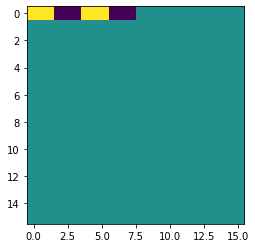

In [9]:
fig = plt.figure()
imgs = []
tm = dvs_events.events[:]["t"]
for t_frame in t_frames:
    t0_us = t_frame
    t1_us = t_frame + dt_frame_us
    t = dvs_events.events[:]["t"]
    m = (t >= t0_us) & (t < t1_us)
    events_m = dvs_events.events[m]

    # show "off" (0) events as -1 and "on" (1) events as +1
    events_sign = 2.0 * events_m["p"] - 1

    frame_img = np.zeros((dvs_height, dvs_width))
    frame_img[events_m["y"], events_m["x"]] = events_sign

    img = plt.imshow(frame_img, vmin=-1, vmax=1, animated=True)
    imgs.append([img])

In [10]:
ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_html5_video())

In [11]:
del dvs_events

In [12]:
pool = (10, 10)

gain = 101

with nengo.Network() as net:
    dvs_process = nengo_loihi.dvs.DVSFileChipProcess(
        file_path=events_file_name, pool=pool, channels_last=True
    )
    u = nengo.Node(dvs_process)

    ensembles = [
        nengo.Ensemble(
            dvs_process.height * dvs_process.width,
            1,
            neuron_type=nengo.SpikingRectifiedLinear(),
            gain=nengo.dists.Choice([gain]),
            bias=nengo.dists.Choice([0]),
        )
        for _ in range(dvs_process.polarity)
    ]

    for k, e in enumerate(ensembles):
        u_channel = u[k :: dvs_process.polarity]
        nengo.Connection(u_channel, e.neurons, transform=1.0 / np.prod(pool))

    probes = [nengo.Probe(e.neurons) for e in ensembles]

with nengo_loihi.Simulator(net) as sim:
    sim.run(t_length)

sim_t = sim.trange()
shape = (len(sim_t), dvs_process.height, dvs_process.width)
output_spikes_neg = sim.data[probes[0]].reshape(shape) * sim.dt
output_spikes_pos = sim.data[probes[1]].reshape(shape) * sim.dt

C:\Users\Monika\anaconda3\envs\AAWP\lib\site-packages\nengo_loihi\builder\ensemble.py:157: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on SpikingRectifiedLinear neurons. On the chip, all values will be initialized to zero.
  % (key, type(neuron_type).__name__)
